In [17]:
import random
import tensorflow as tf
import tensorflow.keras.backend as K

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pickle
import gower
import pydot

from pymoo.factory import get_decision_making
dm = get_decision_making("high-tradeoff")

In [18]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

<h5>Loading models</h5>

In [19]:
# input files provided in https://www.kaggle.com/c/ieee-fraud-detection/
train = pd.read_csv('input/train_transaction.csv').drop(['TransactionID', 'TransactionDT'], axis=1)

In [20]:
dice_results = pickle.load(open('dice_results_clf.pkl', 'rb'))
alibi_results = pickle.load(open('alibi_results_clf.pkl', 'rb'))
xmoai_results = pickle.load(open('xmoai_results_clf.pkl', 'rb'))

[_, X_test_alibi, X_test_dice, y_test] = pickle.load(open('validation_dataset.pkl', 'rb'))
[cat_columns, cat_object_columns, cat_vars_ord, numerical_columns, integer_columns, features, enc] = pickle.load(open('encoder_data.pkl', 'rb'))

In [21]:
model_clf = tf.keras.models.load_model('model_clf')
model_clf_proba = tf.keras.models.load_model('model_clf_proba')

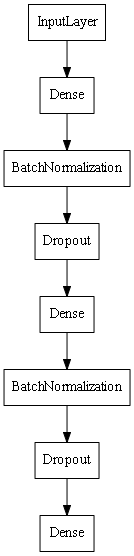

In [62]:
tf.keras.utils.plot_model(model_clf, to_file='model_clf_out.png', show_shapes=False, dpi=72, show_layer_names=False, rankdir='TB')

<h5>Picking the individuals</h5>

In [23]:
chosen_individuals = list(dice_results.keys())

In [24]:
df_originals = train.loc[chosen_individuals]
df_originals_dice = X_test_dice.loc[chosen_individuals]
df_originals_alibi_xmoai = X_test_alibi.loc[chosen_individuals]

In [25]:
train_dice = pd.get_dummies(train, columns=cat_columns, drop_first=False)

In [26]:
df_results = pd.DataFrame()
df_times = pd.DataFrame()

In [27]:
def get_difference_attributes(x, x_original, categorical_columns):
    return gower.gower_matrix(data_x=np.nan_to_num(x.fillna(0), nan=-2**32-1), 
                              data_y=np.nan_to_num(x_original.fillna(0).values.reshape(1, -1), nan=-2**32-1),
                              cat_features=categorical_columns).flatten()

def get_df_times(times, algorithm):
    df_times = pd.DataFrame(times, columns=['Times'])
    df_times['CF'] = algorithm
    
    return df_times

<h5>Analysis - DiCE</h5>

In [28]:
def get_df_results_dice(desired_outcome, original, outputs, cfs):
    # objective 1: distance from the desired value
    obj_1 = outputs if desired_outcome == 0 else desired_outcome - outputs

    # objective 2: Gower distance
    obj_2 = get_difference_attributes(cfs, original, cfs.columns.isin(cat_columns))

    # objective 3: number of modified variables
    obj_3 = np.sum(cfs!=original.values, axis=1).values

    # creating the DataFrame
    df_results = pd.DataFrame(np.array([obj_1, obj_2, obj_3]).T, columns=['Obj 1', 'Obj 2', 'Obj 3'])
    df_results['CF'] = 'DiCE'
    df_results['Index'] = index
    df_results['Valid'] = True
    df_results.loc[df_results['Obj 1']>0.5, 'Valid'] = False
    
    return df_results

In [29]:
def get_outputs_dice(df_originals, index):
    # original outcome
    original = df_originals.loc[index][features.keys()]
    original_ohe = df_originals_dice.loc[index]
    original_outcome = model_clf.predict(np.array([original_ohe]))
    desired_outcome = 0 if original_outcome > 0.5 else 1

    # getting all the counterfactuals
    cfs = []
    for cfs_partial in dice_results[index][0]:
        [cfs.append(cf) for cf in cfs_partial[:,:-1].tolist()]

    cfs = pd.DataFrame(np.unique(np.array(cfs), axis=0), columns=features.keys())
    cfs_ohe = pd.get_dummies(cfs, columns=cat_columns, drop_first=False)

    # inserting additional OHE columns
    additional_cols = list(set(df_originals_dice.columns.tolist()) - set(cfs_ohe.columns.tolist()))
    cfs_ohe[additional_cols] = 0

    # putting in the right order
    cfs_ohe = cfs_ohe[df_originals_dice.columns]

    # converting to the original types
    for col in features.keys():
        if df_originals[col].dtypes != type(object):
            cfs[col] = cfs[col].astype(df_originals[col].dtypes)
    cfs = cfs[original.index]

    # converting to the types as expected by TF
    for col in cfs_ohe.columns:
        if cfs_ohe[col].dtypes == type(object):
            cfs_ohe[col] = cfs_ohe[col].astype('float64')
        else:
            cfs_ohe[col] = cfs_ohe[col].astype('uint8')

    # getting the predictions
    outputs = model_clf.predict(cfs_ohe).flatten()

    # getting the times
    times = dice_results[index][1]
    
    return get_df_results_dice(desired_outcome, original, outputs, cfs), get_df_times(times, 'DiCE')

In [30]:
for index in chosen_individuals:
    results, times = get_outputs_dice(df_originals, index)
    df_results = pd.concat([df_results, results])
    df_times = pd.concat([df_times, times])

<h5>Alibi</h5>

In [31]:
def get_df_results_alibi(desired_outcome, original_ord, outputs, cfs):
    # objective 1: distance from the desired value
    obj_1 = outputs[:,1] if desired_outcome == 0 else outputs[:,0]

    # objective 2: Gower distance
    obj_2 = get_difference_attributes(cfs, original_ord, cfs.columns.isin(cat_columns))

    # objective 3: number of modified variables
    obj_3 = np.sum(cfs!=original_ord.values, axis=1).values

    # creating the DataFrame
    df_results = pd.DataFrame(np.array([obj_1, obj_2, obj_3]).T, columns=['Obj 1', 'Obj 2', 'Obj 3'])
    df_results['CF'] = 'Alibi'
    df_results['Index'] = index
    df_results['Valid'] = True
    df_results.loc[df_results['Obj 1']>0.5, 'Valid'] = False
    
    return df_results

In [32]:
def get_outputs_alibi(df_originals, index):
    # original outcome
    original = df_originals.loc[index][features.keys()]
    original_ord = df_originals_alibi_xmoai.loc[index]
    original_outcome = model_clf_proba.predict(np.array([original_ord]))
    desired_outcome = 0 if np.argmax(original_outcome) == 1 else 1

    # getting all the counterfactuals
    cfs = []
    for cfs_partial in alibi_results[index][0]:
        [cfs.append(cf) for cf in cfs_partial.tolist()]
   
    # getting the times
    times = alibi_results[index][1]
    
    if len(cfs) > 0:
        cfs = pd.DataFrame(np.unique(np.array(cfs), axis=0).reshape(1, -1), columns=features.keys())

        # getting the predictions
        outputs = model_clf_proba.predict(cfs)
    
        return get_df_results_alibi(desired_outcome, original_ord, outputs, cfs), get_df_times(times, 'Alibi')
    else:
        return None, get_df_times(times, 'Alibi')

In [33]:
for index in chosen_individuals:
    results, times = get_outputs_alibi(df_originals, index)
    df_results = pd.concat([df_results, results])
    df_times = pd.concat([df_times, times])

(1177, 6)

(1178, 6)

(1179, 6)

(1180, 6)

(1180, 6)

(1181, 6)

(1182, 6)

(1183, 6)

(1184, 6)

(1185, 6)

<h5>xMOAI</h5>

In [34]:
def get_df_results_xmoai(front, cfs):
    df_results = pd.DataFrame(front, columns=['Obj 1', 'Obj 2', 'Obj 3'])
    df_results['CF'] = 'Proposal'
    df_results['Index'] = index
    df_results['Valid'] = True
    df_results.loc[df_results['Obj 1']>0.5, 'Valid'] = False

    # get only the unique values
    index_to_drop = set(df_results.index) - set(pd.DataFrame(cfs).drop_duplicates().index)
    df_results = df_results.drop(index_to_drop)
    
    return df_results

In [35]:
def get_outputs_xmoai(df_originals, index):
    # original outcome
    original = df_originals.loc[index][features.keys()]
    original_ord = df_originals_alibi_xmoai.loc[index]
    original_outcome = model_clf_proba.predict(np.array([original_ord]))
    desired_outcome = 0 if np.argmax(original_outcome) == 1 else 1

    # getting all the counterfactuals
    cfs = []
    for cfs_partial in xmoai_results[index][0]:
        [cfs.append(cf) for cf in cfs_partial]

    # getting the times
    times = xmoai_results[index][3]

    # getting the objectives
    front = []
    for front_partial in xmoai_results[index][1]:
        [front.append(f) for f in front_partial]

    return get_df_results_xmoai(front, cfs), get_df_times(times, 'xMOAI')

In [36]:
for index in chosen_individuals:
    results, times = get_outputs_xmoai(df_originals, index)
    df_results = pd.concat([df_results, results])
    df_times = pd.concat([df_times, times])

<h5>Plots</h5>

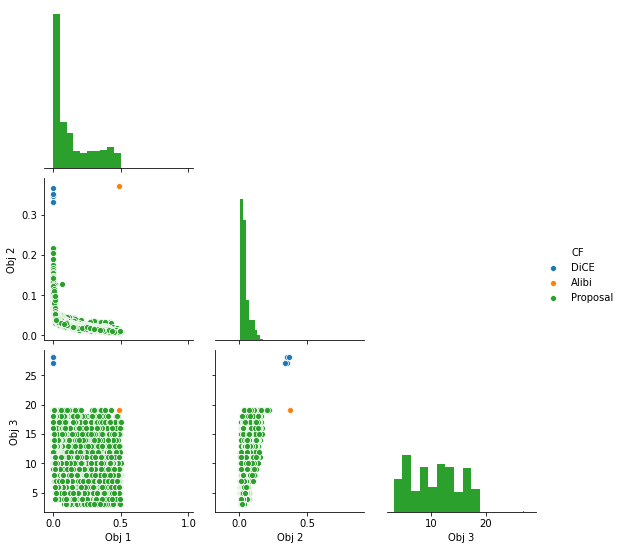

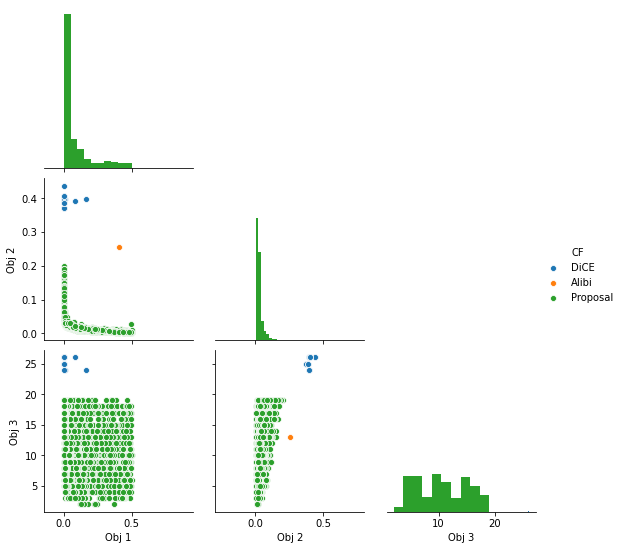

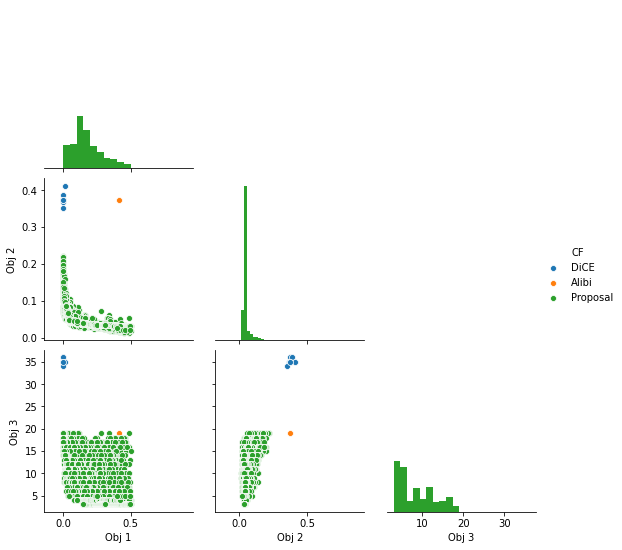

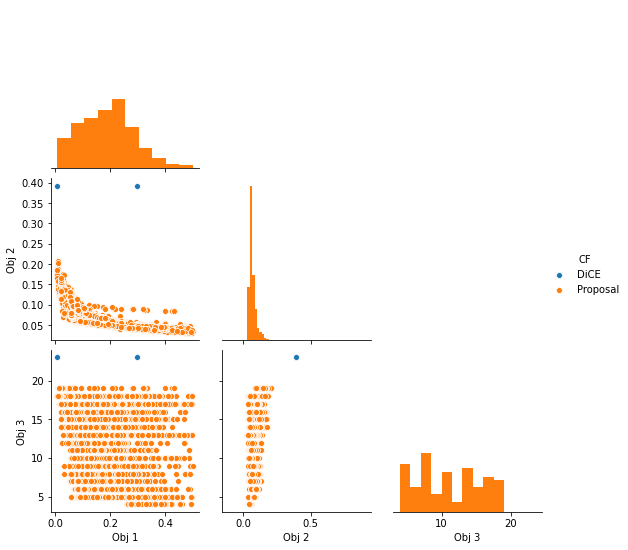

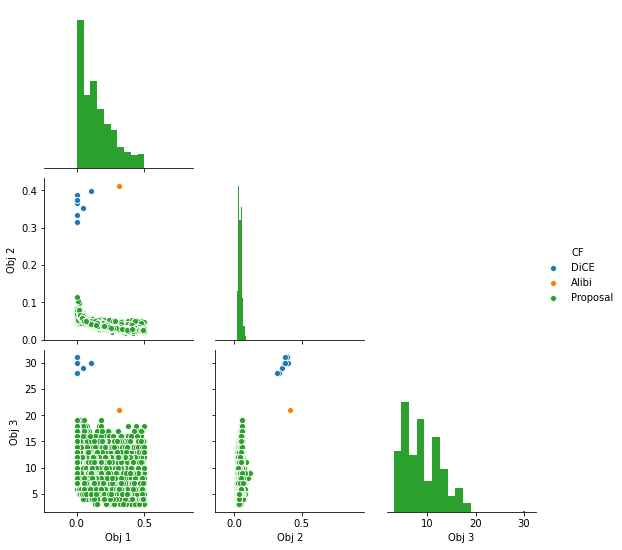

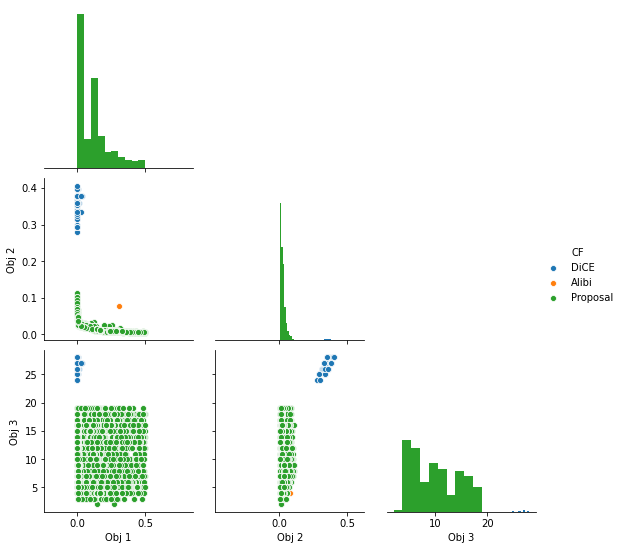

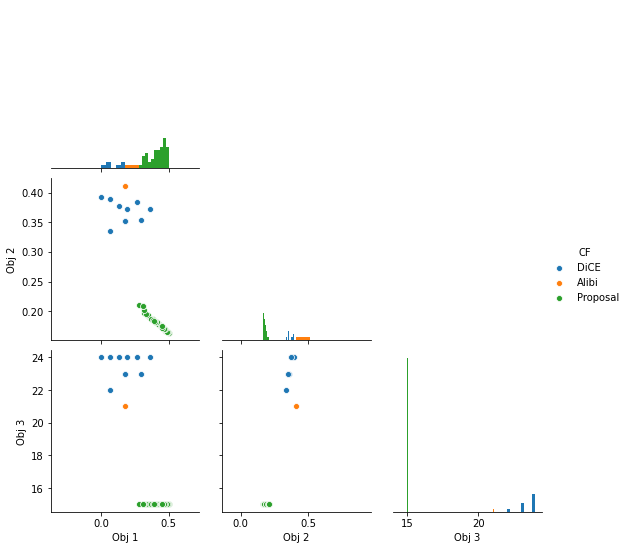

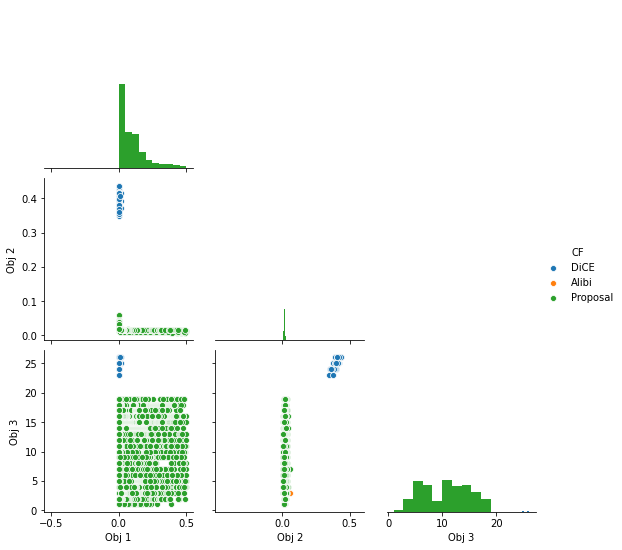

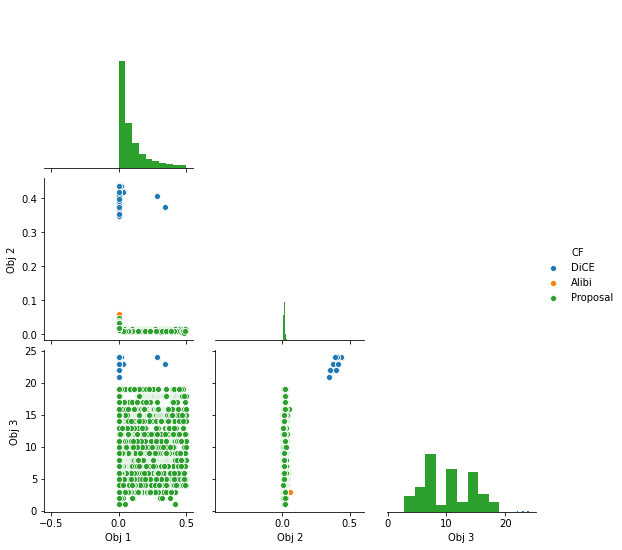

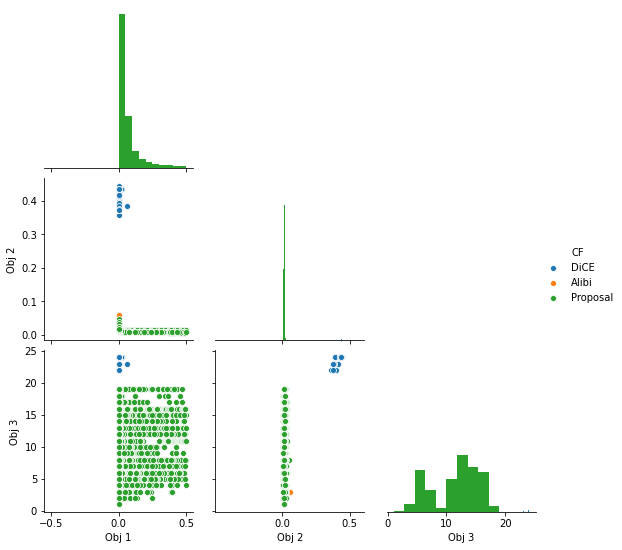

In [37]:
for index in chosen_individuals:
    sns.pairplot(df_results[(df_results['Valid']==True) & (df_results['Index']==index)].drop(['Valid', 'Index'], axis=1), corner=True, hue='CF', diag_kind='hist')

In [38]:
# selecting only the non-dominated solutions
df_non_dominated = df_results.copy().reset_index(drop=True)

dominated_indexes = []
for index in chosen_individuals:
    for technique in df_non_dominated[df_non_dominated['Index']==index]['CF'].unique():
        df_test = df_non_dominated[(df_non_dominated['Index']==index) & (df_non_dominated['CF']==technique)]
        
        for index in df_test.index:
            solution = df_test.loc[index].values
            if np.sum(np.all(solution >= df_test.values, axis=1)) > 1:
                dominated_indexes.append(index)

df_non_dominated = df_non_dominated.drop(dominated_indexes)

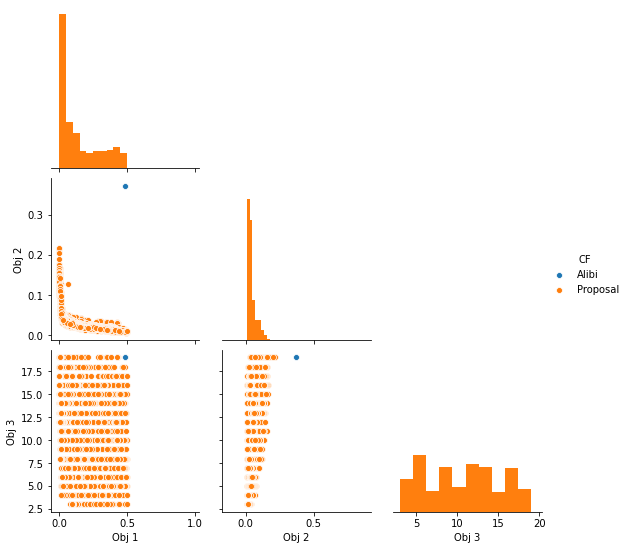

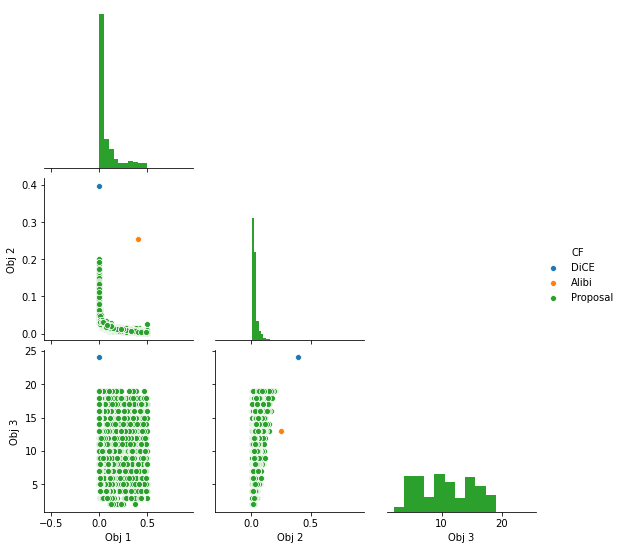

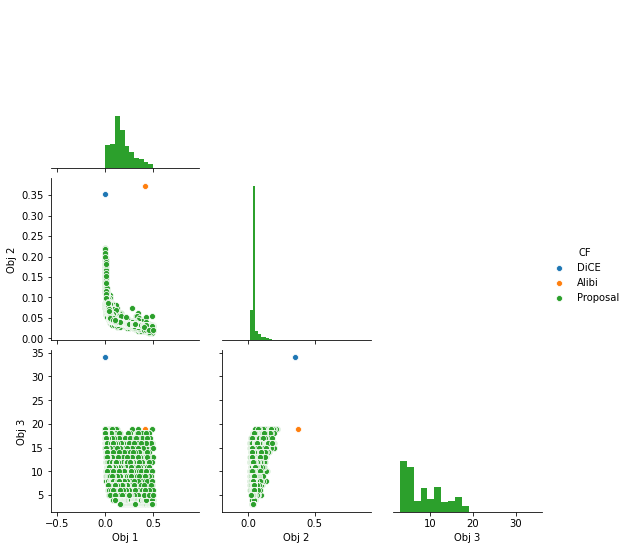

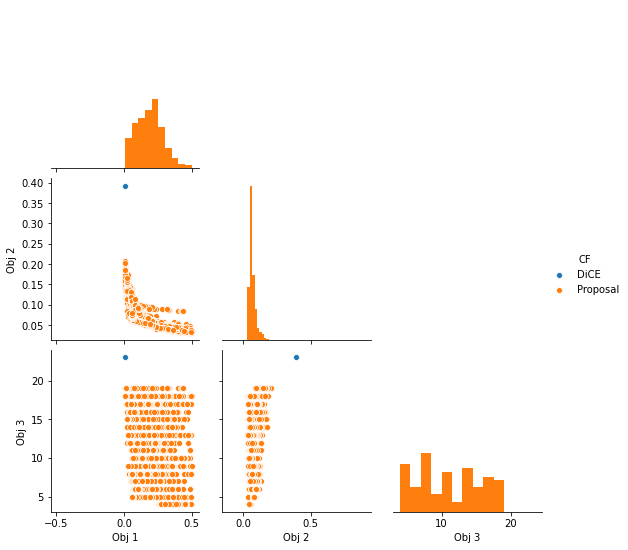

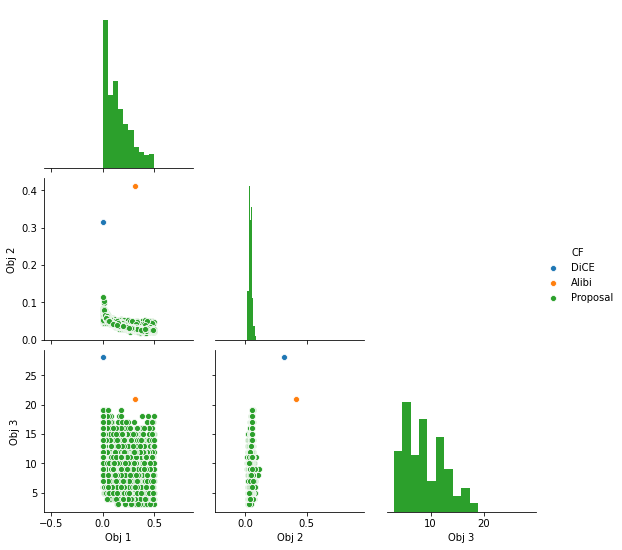

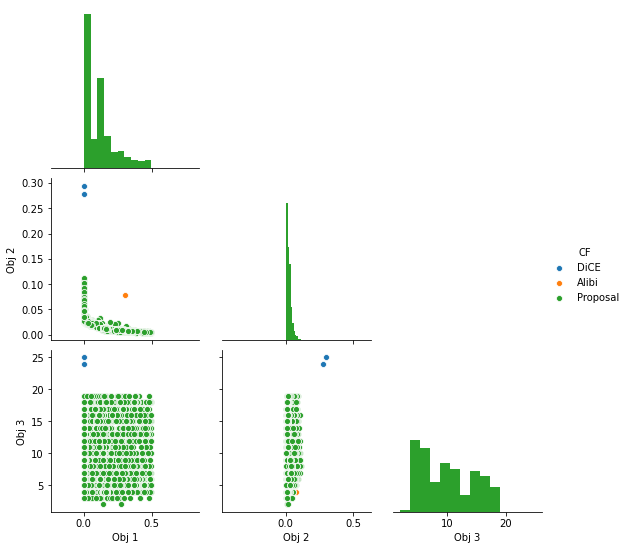

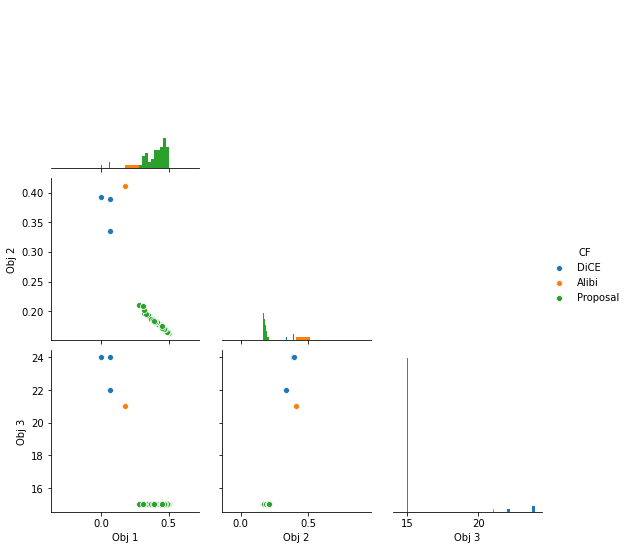

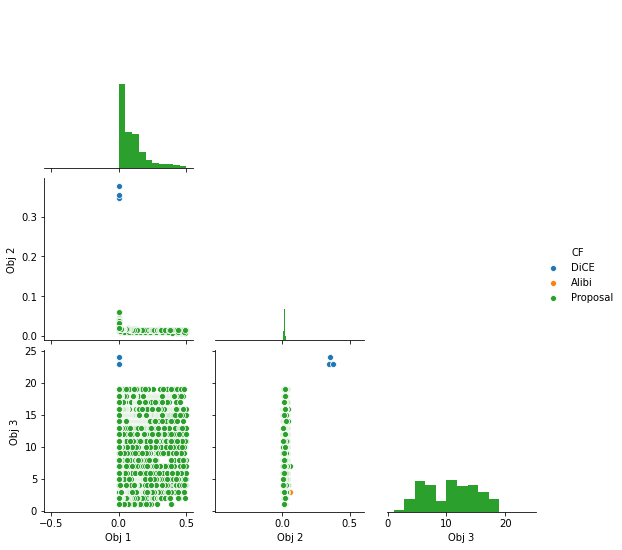

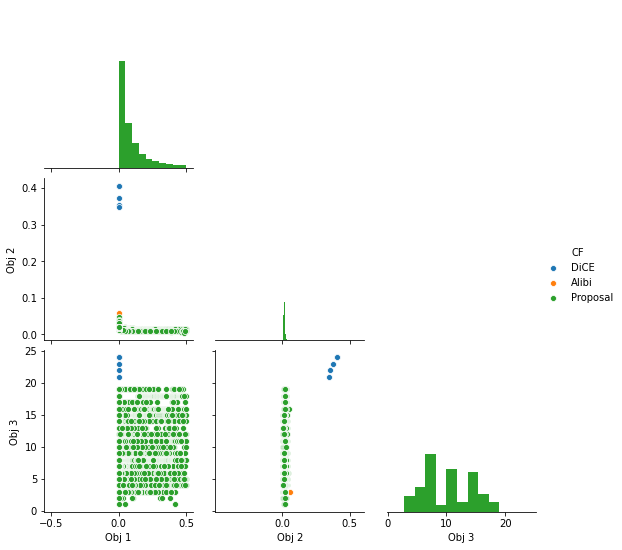

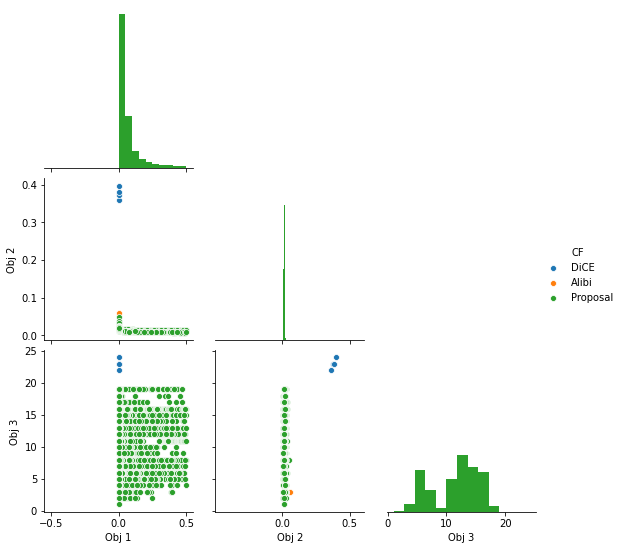

In [39]:
for index in chosen_individuals:
    sns.pairplot(df_non_dominated[(df_non_dominated['Valid']==True) & (df_non_dominated['Index']==index)].drop(['Valid', 'Index'], axis=1), corner=True, hue='CF', diag_kind='hist')

In [40]:
pickle.dump([df_results, df_non_dominated, df_times], open('df_results_classification.pkl', 'wb'))

In [41]:
index = chosen_individuals[0]

In [42]:
markers = {'Alibi': 'o', 'DiCE': 'D', 'Proposal': '^'}
colors = {'Alibi': 'm', 'DiCE': 'r', 'Proposal': 'b'}

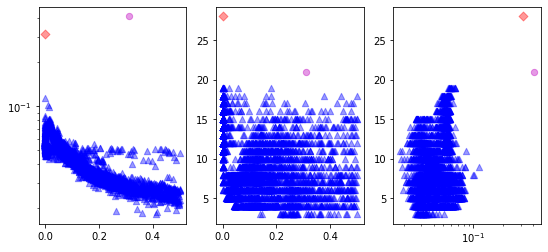

In [45]:
df_test = df_non_dominated[(df_non_dominated['Valid']==True) & (df_non_dominated['Index']==index)]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(9, 4))
s = 40
alpha = 0.4

for technique in np.unique(df_test['CF'].values):
    df_current = df_test[df_test['CF']==technique]
        
    ax1.scatter(df_current['Obj 1'].values, df_current['Obj 2'].values,
                alpha=alpha, s=s, marker=markers[technique], color=colors[technique])
    ax1.set_yscale('log')
    
    ax2.scatter(df_current['Obj 1'].values, df_current['Obj 3'].values,
                alpha=alpha, s=s, marker=markers[technique], color=colors[technique])
    
    ax3.scatter(df_current['Obj 2'].values, df_current['Obj 3'].values,
                alpha=alpha, s=s, marker=markers[technique], color=colors[technique])
    ax3.set_xscale('log')

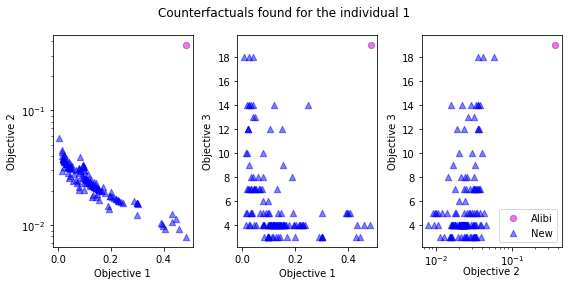

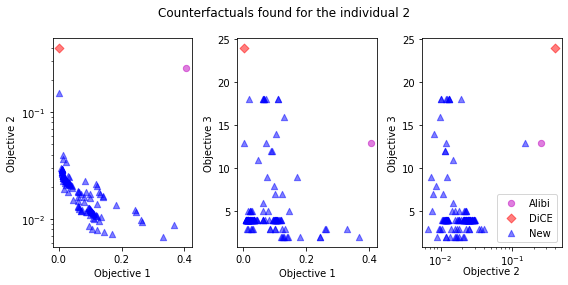

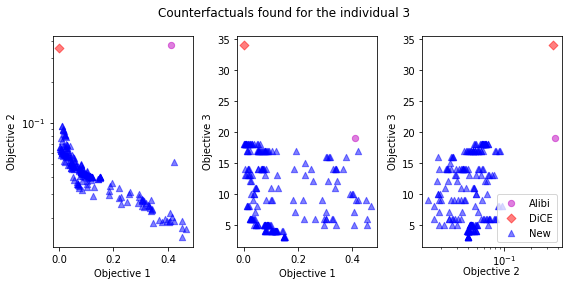

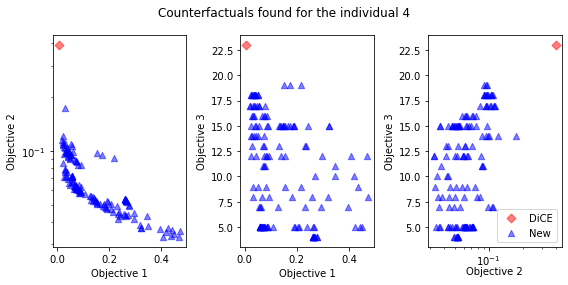

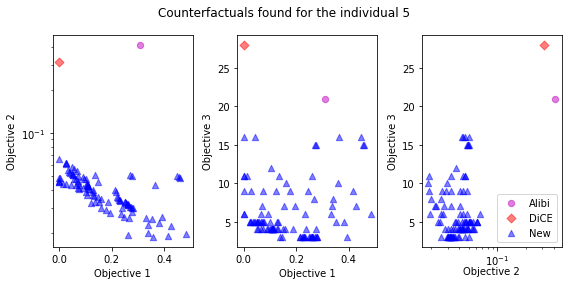

In [46]:
count = 1
for index in chosen_individuals[:5]:
    df_test = df_non_dominated[(df_non_dominated['Valid']==True) & (df_non_dominated['Index']==index)]
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))
    s = 40
    alpha = 0.5

    for technique in np.unique(df_test['CF'].values):
        df_current = df_test[df_test['CF']==technique]

        if technique=='Proposal':
            try:
                df_current = df_current.iloc[dm.do(df_current[['Obj 1', 'Obj 2', 'Obj 3']].values)]
            except:
                display(df_current.shape)
            
            label = 'New'
        else:
            label = technique
                        
        ax1.scatter(df_current['Obj 1'].values, df_current['Obj 2'].values,
                    alpha=alpha, s=s, marker=markers[technique], color=colors[technique], label=label)
        ax1.set_yscale('log')
        ax1.set_xlabel('Objective 1')
        ax1.set_ylabel('Objective 2')

        ax2.scatter(df_current['Obj 1'].values, df_current['Obj 3'].values,
                    alpha=alpha, s=s, marker=markers[technique], color=colors[technique], label=label)
        ax2.set_xlabel('Objective 1')
        ax2.set_ylabel('Objective 3')

        ax3.scatter(df_current['Obj 2'].values, df_current['Obj 3'].values,
                    alpha=alpha, s=s, marker=markers[technique], color=colors[technique], label=label)
        ax3.set_xscale('log')
        ax3.set_xlabel('Objective 2', labelpad=-1)
        ax3.set_ylabel('Objective 3')
        
    plt.legend(loc='lower right')
    
    fig.suptitle(f'Counterfactuals found for the individual {count}')
    plt.tight_layout()
    count += 1

In [47]:
train.loc[chosen_individuals]

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
472433,0,52.811,C,8809,179.0,106.0,visa,137.0,debit,NaN,NaN,NaN,NaN,hotmail.fr,hotmail.fr,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.0,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
472435,0,136.956,C,9633,130.0,185.0,visa,138.0,debit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,2.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.083333,0.083333,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.

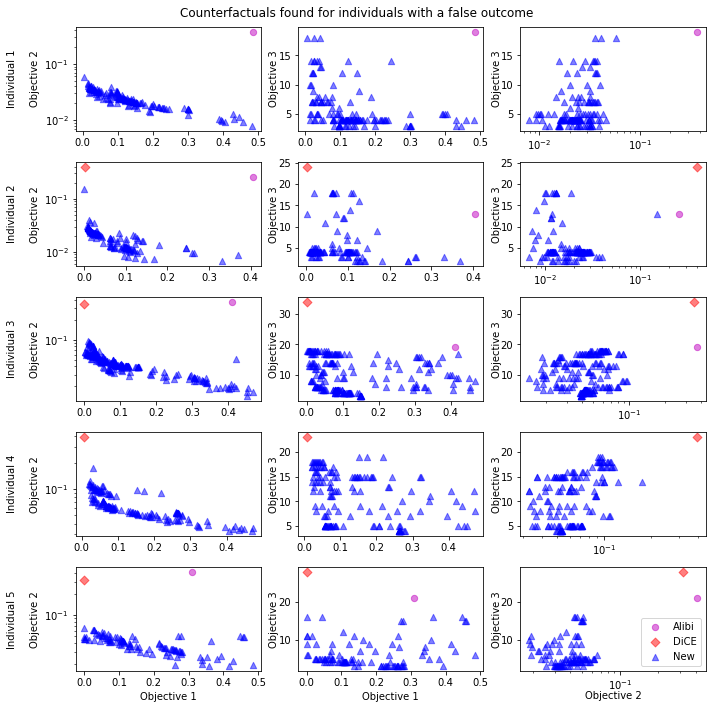

In [51]:
fig = plt.figure(figsize=(10,10))#, constrained_layout=True)
gs0 = gridspec.GridSpec(5, 1, figure=fig)

count = 1
for index in chosen_individuals[:5]:
    df_test = df_non_dominated[(df_non_dominated['Valid']==True) & (df_non_dominated['Index']==index)]
    #fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))
    
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[count-1])
    
    s = 40
    alpha = 0.5

    for technique in np.unique(df_test['CF'].values):
        df_current = df_test[df_test['CF']==technique]

        if technique=='Proposal':
            try:
                df_current = df_current.iloc[dm.do(df_current[['Obj 1', 'Obj 2', 'Obj 3']].values)]
            except:
                display(df_current.shape)
            
            label = 'New'
        else:
            label = technique
                
        ax1 = fig.add_subplot(gs00[:, 0])
        ax1.scatter(df_current['Obj 1'].values, df_current['Obj 2'].values,
                    alpha=alpha, s=s, marker=markers[technique], color=colors[technique], label=label)
        
        ax2 = fig.add_subplot(gs00[:, 1])
        ax2.scatter(df_current['Obj 1'].values, df_current['Obj 3'].values,
                    alpha=alpha, s=s, marker=markers[technique], color=colors[technique], label=label)

        ax3 = fig.add_subplot(gs00[:, 2])
        ax3.scatter(df_current['Obj 2'].values, df_current['Obj 3'].values,
                    alpha=alpha, s=s, marker=markers[technique], color=colors[technique], label=label)
        
        if count == 5:
            ax1.set_xlabel('Objective 1')
            ax2.set_xlabel('Objective 1')
            ax3.set_xlabel('Objective 2', labelpad=-1)

        ax3.set_xscale('log')
        ax1.set_yscale('log')
        
        ax1.set_ylabel(f'Individual {count}\n\nObjective 2')
        ax2.set_ylabel('Objective 3', labelpad=-1)
        ax3.set_ylabel('Objective 3', labelpad=-1)
            
    count += 1
    
plt.legend(loc='lower right')

fig.suptitle(f'Counterfactuals found for individuals with a false outcome')
plt.tight_layout()
plt.savefig('isfraud0.jpg', bbox_inches='tight')

(51, 6)

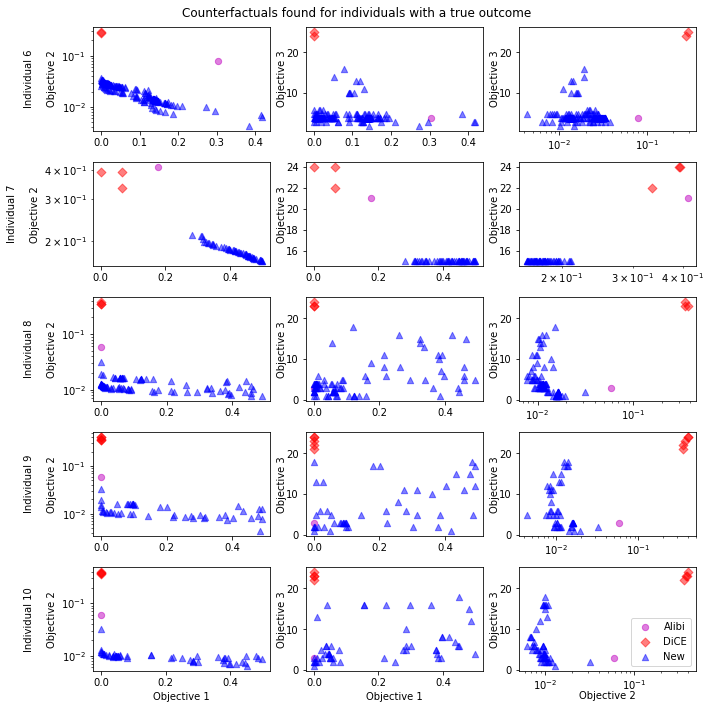

In [52]:
fig = plt.figure(figsize=(10,10))#, constrained_layout=True)
gs0 = gridspec.GridSpec(5, 1, figure=fig)

count = 6
for index in chosen_individuals[5:]:
    df_test = df_non_dominated[(df_non_dominated['Valid']==True) & (df_non_dominated['Index']==index)]
    #fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))
    
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[count-6])
    
    s = 40
    alpha = 0.5

    for technique in np.unique(df_test['CF'].values):
        df_current = df_test[df_test['CF']==technique]

        if technique=='Proposal':
            try:
                df_current = df_current.iloc[dm.do(df_current[['Obj 1', 'Obj 2', 'Obj 3']].values)]
            except:
                display(df_current.shape)
            
            label = 'New'
        else:
            label = technique
                
        ax1 = fig.add_subplot(gs00[:, 0])
        ax1.scatter(df_current['Obj 1'].values, df_current['Obj 2'].values,
                    alpha=alpha, s=s, marker=markers[technique], color=colors[technique], label=label)
        
        ax2 = fig.add_subplot(gs00[:, 1])
        ax2.scatter(df_current['Obj 1'].values, df_current['Obj 3'].values,
                    alpha=alpha, s=s, marker=markers[technique], color=colors[technique], label=label)

        ax3 = fig.add_subplot(gs00[:, 2])
        ax3.scatter(df_current['Obj 2'].values, df_current['Obj 3'].values,
                    alpha=alpha, s=s, marker=markers[technique], color=colors[technique], label=label)
        
        if count == 10:
            ax1.set_xlabel('Objective 1')
            ax2.set_xlabel('Objective 1')
            ax3.set_xlabel('Objective 2', labelpad=-1)

        ax3.set_xscale('log')
        ax1.set_yscale('log')
        
        ax1.set_ylabel(f'Individual {count}\n\nObjective 2')
        ax2.set_ylabel('Objective 3', labelpad=-1)
        ax3.set_ylabel('Objective 3', labelpad=-1)
            
    count += 1
    
plt.legend(loc='lower right')

fig.suptitle(f'Counterfactuals found for individuals with a true outcome')
plt.tight_layout()
plt.savefig('isfraud1.jpg', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(6,4))
df_violin = df_times.copy()
df_violin.loc[df_violin['CF']=='xMOAI', 'CF'] = 'New'
ax = sns.violinplot(x='CF', y='Times', data=df_violin, palette=['red', 'magenta', 'blue'], saturation=0.4)
plt.title('Duration per algorithm (30 runs, 10 individuals per run)')
ax.set_xlabel('Algorithm')
ax.set_ylabel('Duration (s)')
plt.tight_layout()
plt.savefig('times_clf.jpg')

In [ ]:
df_counts = pd.DataFrame(pd.pivot_table(df_non_dominated[df_non_dominated['Valid']==True][['CF', 'Index', 'Valid']], index=['Index'], columns=['CF'], aggfunc='count').fillna(0).to_records())
df_counts['isFraud'] = train.loc[df_counts['Index']]['isFraud'].values
df_counts.to_csv('clf_results.csv')